# Práctica 3. Reconocimiento de Entidades Nombradas. NER

Andrés González Flores

Procesamiento de Lenguaje Natural

Facultad de Ingeniería, UNAM

## Objetivo

Realizar un reconocimiento de Entidades Nombradas (NER) a partir de un modelo secuencial y con el corpus ‘ner dataset.csv’ que se proporciona.

## Instrucciones

Se deberán seguir los siguientes pasos:

1. Obtener las sentencias a partir del csv. En este archivo, se indica cada inicio de sentencia con ‘Sentence: n’. Se cuenta con 1000 sentencias que conformarán el corpus de entrenamiento y evaluación.
2. Preprocesar los datos.
3. Separar los datos en corpus de entrenamiento (70%) y corpus de evaluación (30%).
4. Entrenar un modelo secuencial a partir del corpus de entrenamiento. Deberán definirse los hiperparámetros.
5. Evaluar el desempeño del sistema a partir del corpus de evaluación y con la métrica de Exactitud (Accuracy).
6. Ejemplificar el reconocimiento de entidades nombradas con 5 sentencias del corpus de evaluación.

## Dessarrollo

In [1]:
import csv
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import operator
from itertools import chain
from tqdm.notebook import tqdm
from pprint import pprint

In [2]:
# Definición de constantes
SEED = 42
CORPUS_PATH = './ner_dataset.csv'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

np.random.seed(SEED)

### Paso 1. Obtener sentencias.


In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    csvlist = list(reader)

In [4]:
sentences = []
sent_i = []
for row in csvlist[1:]:
    if row[0] is not '':
        sentences.append(sent_i)
        sent_i = []
    sent_i.append((row[1], row[2]))
# Mi algoritmo está feo: agrega la primer sentencia vacía y no agrega la última
del sentences[0]
sentences.append(sent_i)

In [5]:
print(f'Número de oraciones = {len(sentences)}\n')
print('Ejemplos:')
print('\n'.join([' '.join([w for w, tag in sent]) for sent in sentences[:5] ]))

Número de oraciones = 1000

Ejemplos:
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
They marched from the Houses of Parliament to a rally in Hyde Park .
Police put the number of marchers at 10000 while organizers claimed it was 1,00,000 .
The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .


### Paso 2. Preprocesamiento

In [6]:
freq_tokens = Counter([w for w,_ in chain(*sentences)])
freq_tokens.most_common(10)

[('the', 1111),
 ('.', 995),
 (',', 637),
 ('in', 576),
 ('of', 568),
 ('to', 505),
 ('a', 449),
 ('and', 391),
 ('The', 241),
 ("'s", 202)]

Agrego el diccionario de entrada

In [7]:
word_to_index = { 
    x[0] : i for i, x in enumerate(freq_tokens.most_common())
    if freq_tokens[x[0]] > 1
}

pprint(list(word_to_index.items())[:10])

[('the', 0),
 ('.', 1),
 (',', 2),
 ('in', 3),
 ('of', 4),
 ('to', 5),
 ('a', 6),
 ('and', 7),
 ('The', 8),
 ("'s", 9)]


Agrego los identificadores UNK, BOS Y EOS al vocabulario de entrada

In [8]:
word_to_index[UNK] = max(word_to_index.values())+1
word_to_index[BOS] = word_to_index[UNK]+1
word_to_index[EOS] = word_to_index[BOS]+1

pprint(list(word_to_index.items())[-10:])

[('collapse', 2102),
 ('Barno', 2103),
 ('reunification', 2104),
 ('Berlin', 2105),
 ('Kohl', 2106),
 ('proud', 2107),
 ('wall', 2108),
 ('<unk>', 2109),
 ('<BOS>', 2110),
 ('<EOS>', 2111)]


Agrego el vocabulario de salida (las etiquetas)

In [9]:
freq_tags = Counter([tag for _,tag in chain(*sentences)])
freq_tags.most_common()

[('', 18843),
 ('B-ge', 583),
 ('B-gpe', 543),
 ('B-rg', 413),
 ('I-per', 400),
 ('B-tim', 358),
 ('B-per', 327),
 ('I-rg', 290),
 ('I-ge', 105),
 ('I-tim', 77),
 ('B-art', 39),
 ('I-gpe', 26),
 ('I-art', 22),
 ('B-eve', 20),
 ('I-eve', 16),
 ('B-nat', 9),
 ('I-nat', 5)]

In [10]:
tag_to_index = {
    y[0] : i for i, y in enumerate(freq_tags.most_common())
}
pprint(tag_to_index)

{'': 0,
 'B-art': 10,
 'B-eve': 13,
 'B-ge': 1,
 'B-gpe': 2,
 'B-nat': 15,
 'B-per': 6,
 'B-rg': 3,
 'B-tim': 5,
 'I-art': 12,
 'I-eve': 14,
 'I-ge': 8,
 'I-gpe': 11,
 'I-nat': 16,
 'I-per': 4,
 'I-rg': 7,
 'I-tim': 9}


Creo los vocabularios inversos

In [11]:
index_to_word = [w for w in word_to_index.keys()]
print(f'Tamaño del vocabulario: {len(index_to_word)}')
print('Ejemplos de palabras:')
print(', '.join(index_to_word[::350]))
print()

index_to_tag = [tag for tag in tag_to_index.keys()]
print('Vocabulario de etiquetas:')
pprint(', '.join(index_to_tag))

Tamaño del vocabulario: 2112
Ejemplos de palabras:
the, parliament, measure, claim, flown, burning, Tokar

Vocabulario de etiquetas:
(', B-ge, B-gpe, B-rg, I-per, B-tim, B-per, I-rg, I-ge, I-tim, B-art, I-gpe, '
 'I-art, B-eve, I-eve, B-nat, I-nat')


Creo un método que devuelve siempre un indice del vocabulario o el identificador UNK

In [12]:
def word_safe_vocab_index(w, vocab, ix_UNK):
    try:
        return vocab[w]
    except KeyError:
        return ix_UNK

Armo el corpus de entrenamiento

In [13]:
ix_UNK = word_to_index[UNK]
ix_BOS = word_to_index[BOS]
ix_EOS = word_to_index[EOS]

BOS_append = [(ix_BOS, tag_to_index[''])] # BOS y su etiqueta
EOS_append = [(ix_EOS, tag_to_index[''])] # EOS y su etiqueta

corpus = [
    BOS_append + [ # Agrego BOS y su etiqueta
        # Tupla con el valor del índice de la palabra y el índice de la etiqueta
        (
            word_safe_vocab_index(w, word_to_index, ix_UNK),
            tag_to_index[tag]
        ) # Fin tupla
        for w, tag in sent # Para cada palabra en la sentencia
    ] + EOS_append # Fin append
    for sent in sentences # Por cada sentencia en la lista de sentencias
]
# pprint(corpus[:5])
print('\n\n'.join([' '.join([f'({ix_w}, {ix_tag})' for ix_w, ix_tag in sent]) for sent in corpus[:5] ]))

(2110, 0) (904, 0) (4, 0) (905, 0) (14, 0) (906, 0) (243, 0) (244, 1) (5, 0) (298, 0) (0, 0) (127, 0) (3, 0) (53, 1) (7, 0) (1282, 0) (0, 0) (679, 0) (4, 0) (99, 2) (77, 0) (17, 0) (16, 0) (71, 0) (1, 0) (2111, 0)

(2110, 0) (2109, 0) (4, 0) (177, 0) (31, 0) (3, 0) (0, 0) (680, 0) (551, 0) (0, 0) (458, 0) (59, 0) (459, 0) (2109, 0) (18, 0) (245, 0) (1283, 0) (25, 0) (28, 0) (200, 6) (2109, 0) (460, 0) (2109, 0) (28, 0) (7, 0) (28, 0) (2109, 0) (0, 0) (2109, 0) (1, 0) (28, 0) (2111, 0)

(2110, 0) (134, 0) (906, 0) (17, 0) (0, 0) (2109, 0) (4, 0) (2109, 0) (5, 0) (6, 0) (1284, 0) (3, 0) (2109, 1) (2109, 8) (1, 0) (2111, 0)

(2110, 0) (268, 0) (340, 0) (0, 0) (341, 0) (4, 0) (1285, 0) (22, 0) (1286, 0) (135, 0) (1287, 0) (299, 0) (32, 0) (19, 0) (2109, 0) (1, 0) (2111, 0)

(2110, 0) (8, 0) (298, 0) (552, 0) (15, 0) (0, 0) (1288, 0) (4, 0) (0, 0) (387, 0) (553, 0) (4, 0) (554, 1) (9, 0) (907, 0) (461, 3) (462, 7) (3, 0) (0, 0) (128, 0) (2109, 2) (2109, 0) (2109, 0) (4, 0) (2109, 1) (1, 0) 

### Paso 3. Separar corpus de entrenamiento y evaluacion

In [14]:
train_corpus, val_corpus = train_test_split(corpus, test_size=0.3, random_state=SEED)
print("Ejemlos del corpus de entrenamiento")
for sent in train_corpus[:5]:
    print(sent)
print()
print("Ejemlos del corpus de validación")
for sent in val_corpus[:5]:
    print(sent)

Ejemlos del corpus de entrenamiento
[(2110, 0), (123, 0), (13, 0), (0, 0), (692, 0), (341, 0), (4, 0), (178, 0), (1599, 0), (636, 0), (1211, 0), (11, 0), (326, 0), (480, 0), (5, 0), (2109, 0), (129, 0), (2, 0), (171, 0), (1670, 0), (1, 0), (2111, 0)]
[(2110, 0), (8, 0), (487, 0), (19, 0), (1776, 0), (27, 0), (0, 0), (131, 0), (668, 0), (3, 0), (2109, 1), (2, 0), (7, 0), (0, 0), (2109, 0), (4, 0), (50, 6), (667, 4), (2, 0), (6, 0), (2109, 0), (4, 0), (2109, 2), (49, 6), (2109, 4), (2109, 4), (2, 0), (19, 0), (13, 0), (5, 0), (565, 0), (1777, 0), (5, 0), (340, 0), (46, 0), (1778, 0), (15, 0), (2109, 2), (1, 0), (2111, 0)]
[(2110, 0), (443, 0), (51, 0), (56, 0), (2, 0), (606, 2), (144, 6), (93, 4), (2109, 4), (2109, 4), (543, 0), (24, 0), (254, 3), (2109, 0), (11, 0), (331, 0), (538, 0), (82, 0), (4, 0), (224, 2), (9, 0), (175, 0), (2, 0), (348, 1), (1, 0), (2111, 0)]
[(2110, 0), (1507, 0), (609, 0), (39, 0), (2109, 0), (199, 0), (46, 0), (633, 0), (7, 0), (52, 0), (1467, 0), (5, 0), (210

In [15]:
train_Data = [list(zip(*sent)) for sent in train_corpus]
val_Data = [list(zip(*sent)) for sent in val_corpus]

### Paso 4. Selección de modelo y entrenamiento

Usaré un modelo de red neuronal recurrente con una capa de embedding, una capa oculta de recurrencia, y una capa de salida.

La capa de embedding se define como:

$$ x = Cs $$

$C$ es una matriz de dimensión $d\times N_{in}$ y $s$ es la representación one hot de la palabra en la secuencia.

La capa oculta recurrente:

$$ h^{(t)} = \tanh{(Vh^{(t-1)}+Ux^{(t)})} $$

$V$ es una matriz de dimensión $m\times m$, $U$ una matriz de dimensión $d\times m $.

Y la capa de salida:

$$ y^{(t)} = Softmax(Wh^{(t-1)}+c) $$

En donde $W$ es una matriz de dimensión $N_{out} \times m$

Los valores de $d$ y $m$ son hiperparámetros

#### Función de Riesgo

La función de riesgo será la entroía cruzada:

$$ R(y, \hat{y}) = -\frac1N \sum_{i=0}^Ny\log\hat{y_i} $$

Defino los hiperparámetros del modelo

In [16]:
dim_in = len(index_to_word)
dim_d = 32 # Embedding
dim_m = 16 # Celda recurrente
dim_out = len(tag_to_index)

print(f'Dimensión de entrada: {dim_in}')
print(f'Dimensión de salida: {dim_out}')
print(f'Dimensión de capa de embedding: {dim_d}')
print(f'Dimensión de capa oculta: {dim_m}')

Dimensión de entrada: 2112
Dimensión de salida: 17
Dimensión de capa de embedding: 32
Dimensión de capa oculta: 16


Defino función para calcular accuracy

In [17]:
calc_acc = lambda conf_mat : np.diag(conf_mat).sum()/conf_mat.sum()

Defino la clase del modelo de red recurrente

In [18]:
class Modelo(object):
    def __init__(self, d, m, N_in, N_out):
        self.d = d # DImensión de capa de embedding
        self.m = m # Dimensión de capa oculta
        self.N_in = N_in # Dimensión de entrada
        self.N_out = N_out # Dimensión de salida

    def inicializar_pesos(self):
        # Capa de embedding
        self.C = np.random.randn(self.d, self.N_in) / np.sqrt(self.N_in)
                
        # Capa recurrente oculta
        self.V = np.random.randn(self.m, self.m) / np.sqrt(self.m)
        self.U = np.random.randn(self.m, self.d) / np.sqrt(self.d)

        # Capa de salida
        self.W = np.random.randn(self.N_out, self.m) / np.sqrt(self.m) 
        self.c = np.zeros(self.N_out)
        
        # Los mejores pesos del modelo
        self.best_C = self.C        
        self.best_V = self.W
        self.best_U = self.U
        self.best_W = self.W
        self.best_c = self.c
    
    def forward(self, secuencia):
        """Paso hacia adelante de la red. 
        Recibe como argumento una secuencia de entrada de n elementos, estos elementos
        deben ser indices del vocabulario de entrada.
        Da como salida $n$ vectores $h$, y $n$ vectores $y$
        """
        # Tamaño de la secuencia de entrada
        T = len(secuencia)

        # Prealojamiento de salidas por estado de capas oculta y de salida.
        h = np.zeros((T+1, self.m)) # Uso un estado adicional para t = -1
        # Se inicia el vector h[-1] con ceros
        h[-1] = np.zeros(self.m)

        y = np.zeros((T, self.N_out))
        x_emb = np.zeros((T, self.d))


        # Propagación hacia adelante de la secuenca de entrada
        for t in range(T):
            # Un paso en la capa embedding se reduce a C[:, s]
            x_emb[t] = self.C[:, secuencia[t]]

            # Capa oculta recurrente
            Vh = self.V.dot(h[t-1])
            Ux = self.U.dot(x_emb[t])
            h[t] = np.tanh(Vh + Ux) # Salida de capa oculta

            # Capa de salida
            a = self.W.dot(h[t]) + self.c # Preactivación
            exp_a = np.exp(a - a.max()) # Exponencial de la preactivación
            y[t] = exp_a/exp_a.sum() # Salida Softmax        
        return y, h, x_emb
    
    def predecir(self, secuencia):
        y_hat, _, _ = self.forward(secuencia)
        return np.argmax(y_hat, axis=1)

    def backprop(self, x, y, fw_out):
        """Algoritmo de backpropagation. 
        x es una secuencia de T elementos. 
        y es una secuencia de T elementos. 
        fw_out es una tupla de tres elementros (out, h, x_emb). Contiene
        la salida de la red, la salida de la capa oculta y la salida de la
        capa de embedding.
        """
        T = len(y) # Número de entidades en la secuencia
        # output, h, x_emb = self.forward(x)
        output, h, x_emb = fw_out
        
        # Derivadas respecto a las matrices U, V, W, C y el vector c
        dLdU = np.zeros_like(self.U)
        dLdV = np.zeros_like(self.V)

        dLdW = np.zeros_like(self.W)
        dLdc = np.zeros_like(self.c)
        
        dLdC = np.zeros_like(self.C)

        # Backprop
        # Copio el arreglo para no modificar pesos de la salida original
        d_out = np.array(output, copy=True) 
        # Modifico todos los arreglos en el tiempo
        # En cada indice contenido en y, le resto 1
        d_out[np.arange(len(y)), y] -= 1  # p(Tag_k | w_i) - y_k
        
        # Backprop a través del tiempo
        for t in np.arange(T-1,-1,-1): # Desde T hasta 0
            # Derivada de la capa de salida
            dLdW += np.outer(d_out[t], h[t].T)
            dLdc += d_out[t]

            # Variable de celda recurrente
            d_h = self.W.T.dot(d_out[t])*(1-h[t]**2)

            # Variable de la capa de embedding
            d_emb = self.U.T.dot(d_h)            
            
            # Truncamos la propagación a 4 palabras anteriores a la actual
            for step in np.arange(max(0, t-4), t+1)[::-1]:
                # Derivadas de capa recurrente
                dLdV += np.outer(d_h, h[step-1])
                dLdU += np.outer(d_h, x_emb[step])

                dLdC[:, x[step]] += d_emb

                # Actualizamos variable de celda recurrente
                d_h = self.V.T.dot(d_h) * (1-h[step-1]**2)

                # Actualizamos variable de embedding
                d_emb = self.U.T.dot(d_h)

        return dLdC, dLdU, dLdV, dLdW, dLdc

    def gradiente_descendente(self, gradientes, lr=0.01):
        """Método que da un paso en el gradiente descendiente, actualizando los pesos.
        Recibe una tupla con los valores de los gradientes  (dLdC, dLdU, dLdV, dLdW, dLdc)
        """
        # Desenvolver gradientes
        dLdC, dLdU, dLdV, dLdW, dLdc = gradientes
        
        # Actualizamos los pesos
        # Capa de salida
        self.W -= lr*dLdW
        self.c -= lr*dLdc
        # Capa recurrente oculta
        self.V -= lr*dLdV
        self.U -= lr*dLdU
        # Capa de embredding
        self.C -= lr*dLdC # Las demás filas no nos interesan, porque son 0
        
    def entrenar(self, train_Data, val_Data, epochs=50, lr=0.1, mostrar_res_cada = 5):
        # Historial para guardar las métricas
        history = { 
            k : {
                'loss' : np.zeros(epochs),
                'conf_mat' : np.zeros((epochs, self.N_out, self.N_out)),
            }
            for k in ['train', 'val']
        }
        min_train_loss = np.inf
        min_val_loss = np.inf

        for epoch in tqdm(np.arange(epochs)):

            # TRAIN
            train_loss = 0
            train_len = len(train_Data)
            train_conf_mat = np.zeros((self.N_out, self.N_out))
            np.random.shuffle(train_Data)
            for x, y in train_Data:
                # FORWARD
                len_seq = len(y)
                fw_out = self.forward(x)

                y_hat = fw_out[0]
                # La probabilidad de la "y" verdadera
                y_hat_n = y_hat[np.arange(len(y)), y]
                # RIESGO
                train_loss -= np.sum(np.log(y_hat_n))/len_seq

                # Matriz de confusión
                y_pred = np.argmax(y_hat, axis=1)
                train_conf_mat[y, y_pred] += 1 # Sumo uno en las intersecciones
                
                # BACKPROP
                grads = self.backprop(x, y, fw_out)
                self.gradiente_descendente(grads, lr)
            
            train_loss /= train_len

            if train_loss < min_train_loss:
                min_train_loss = train_loss
                self.guardar_pesos('pesos_modelos/best_loss_train.npz')

            history['train']['conf_mat'][epoch,:,:] = train_conf_mat
            history['train']['loss'][epoch] = train_loss

            # VALIDATION
            val_loss = 0
            val_len = len(val_Data)
            val_conf_mat = np.zeros((self.N_out, self.N_out))
            np.random.shuffle(val_Data)
            for x, y in val_Data:
                # FORWARD
                len_seq = len(y)
                fw_out = self.forward(x)

                y_hat = fw_out[0]
                # La probabilidad de la "y" verdadera
                y_hat_n = y_hat[np.arange(len(y)), y]
                # RIESGO
                val_loss -= np.sum(np.log(y_hat_n))/len_seq

                # Matriz de confusión
                y_pred = np.argmax(y_hat, axis=1)
                val_conf_mat[y, y_pred] += 1 # Sumo uno en las intersecciones
            val_loss /= val_len

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                self.guardar_pesos('pesos_modelos/best_loss_val.npz')

            history['val']['conf_mat'][epoch,:,:] = val_conf_mat
            history['val']['loss'][epoch] = val_loss

            if epoch % mostrar_res_cada == 0:
                train_acc = calc_acc(train_conf_mat)
                val_acc = calc_acc(val_conf_mat)
                tqdm.write(
                    f'Epoch {epoch+1:3}.' +
                    f'\tloss: {train_loss:2.5f}\tacc: {train_acc:2.5f}'+
                    f'\tval_loss: {val_loss:2.5f}\tval_acc: {val_acc:2.5f}')

        return history
    
    def cargar_mejores_pesos(self):
        self.C = self.best_C
        self.U = self.best_U
        self.V = self.best_V
        self.W = self.best_W
        self.c = self.best_c
    
    def guardar_pesos(self, archivo):
        """Guarda los pesos del modelo en formato .npz
        """
        try:
            np.savez(
                archivo, 
                C = self.C, 
                U = self.U, 
                V = self.V, 
                W = self.W, 
                c = self.c
            )
            # print(f'Archivo {archivo} guardado satisfactoriamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
    
    def cargar_pesos(self, archivo):
        """Carga los pesos del modelo guardados en un archivo formato .npz
        """
        try:
            pesos = np.load(archivo)
            self.C = pesos['C']
            self.U = pesos['U']
            self.V = pesos['V']
            self.W = pesos['W']
            self.c = pesos['c']
            print(f'Pesos desde {archivo} cargados correctamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
        

#### Instancio el modelo

In [19]:
modelo = Modelo(d = dim_d, m=dim_m, N_in = dim_in, N_out = dim_out)
modelo.inicializar_pesos()

Comienzo el entrenamiento

In [20]:
history = modelo.entrenar(train_Data, val_Data, epochs=350, lr=0.1, mostrar_res_cada=30)

Epoch   1.	loss: 0.90852	acc: 0.26838	val_loss: 0.96630	val_acc: 0.24779
Epoch  31.	loss: 0.50268	acc: 0.44892	val_loss: 0.49565	val_acc: 0.44178
Epoch  61.	loss: 0.44560	acc: 0.49983	val_loss: 0.52092	val_acc: 0.45362
Epoch  91.	loss: 0.44254	acc: 0.49015	val_loss: 0.49969	val_acc: 0.48316
Epoch 121.	loss: 0.46851	acc: 0.48907	val_loss: 0.50308	val_acc: 0.45600
Epoch 151.	loss: 0.45209	acc: 0.49792	val_loss: 0.56086	val_acc: 0.37594
Epoch 181.	loss: 0.45276	acc: 0.49038	val_loss: 0.52575	val_acc: 0.46742
Epoch 211.	loss: 0.46971	acc: 0.48118	val_loss: 1.08949	val_acc: 0.33560
Epoch 241.	loss: 0.46585	acc: 0.48404	val_loss: 0.54556	val_acc: 0.44132
Epoch 271.	loss: 0.45922	acc: 0.46723	val_loss: 0.58335	val_acc: 0.45484
Epoch 301.	loss: 0.46629	acc: 0.48360	val_loss: 0.58852	val_acc: 0.44861
Epoch 331.	loss: 0.45462	acc: 0.49116	val_loss: 0.55669	val_acc: 0.45353



### Paso 5. Evaluar modelo

Evaluar el desempeño del sistema a partir del corpus de evaluación y con la métrica de Exactitud (Accuracy).

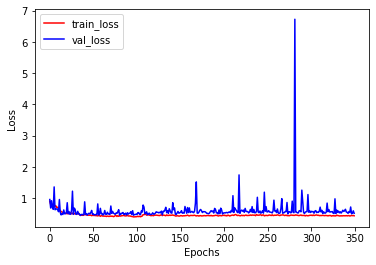

In [21]:
plt.plot(history['train']['loss'], color='red', label='train_loss')
plt.plot(history['val']['loss'], color='blue', label='val_loss')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig(f'./img/modelo_v1_loss_seed_{SEED}.png')

plt.show()

In [22]:
best_train_epoch = np.argmin(history['train']['loss'])
best_val_epoch = np.argmin(history['val']['loss'])
print(f"Mejor época de entrenamiento: {best_train_epoch}")
print(f"Mejor época de validación: {best_val_epoch}")

Mejor época de entrenamiento: 96
Mejor época de validación: 35


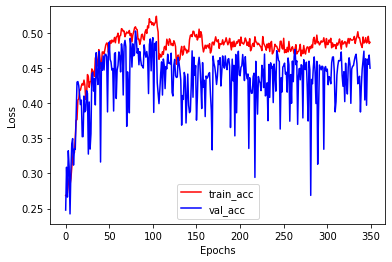

In [23]:
train_acc_hist = [calc_acc(mat) for mat in history['train']['conf_mat']]
val_acc_hist = [calc_acc(mat) for mat in history['val']['conf_mat']]

plt.plot(train_acc_hist, color='red', label='train_acc')
plt.plot(val_acc_hist, color='blue', label='val_acc')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig(f'./img/modelo_v1_acc_seed_{SEED}.png')

plt.show()

In [24]:
best_acc_train_epoch = np.argmax(train_acc_hist)
best_acc_val_epoch = np.argmax(val_acc_hist)
print(f"Mejor época de entrenamiento: {best_acc_train_epoch}")
print(f"Mejor época de validación: {best_acc_val_epoch}")

Mejor época de entrenamiento: 104
Mejor época de validación: 80


In [28]:
modelo.cargar_pesos('pesos_modelos/best_loss_val.npz')

Pesos desde pesos_modelos/best_loss_val.npz cargados correctamente


True

### Paso 6. Probar desempeño

Ejemplificar el reconocimiento de entidades nombradas con 5 sentencias del corpus de evaluación.

In [29]:
for sentence, y in val_Data[:10]: 
    print('='*64)
    pred = modelo.predecir(sentence)
    sent_words = [index_to_word[w] for w in sentence] # Input
    tags_pred = [index_to_tag[t] for t in pred] # Datos predichos
    tags = [index_to_tag[t] for t in y] # Datos reales

    print(f"{'token':>16}{'pred':>16}{'real':>16}")
    print('-'*64)
    for x_i, y_hat_i, y_i in zip(sent_words, tags_pred, tags):
        print(f"{x_i:>16}{y_hat_i:>16}{y_i:>16}")
    print('='*64+'\n')

           token            pred            real
----------------------------------------------------------------
           <BOS>                                
              He                                
            told                                
       reporters                                
              in                                
             the                                
            West            B-ge            B-ge
            Bank            I-ge            I-ge
            that                                
           there                                
              is                                
           still                                
            room                                
             for                                
        progress                                
              in                                
           <unk>                                
    negotiations                                
    